In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

## Key Ideas
If we have only aggregated level data, we can't apply diff-in-Diff model,
since it has to define a control unit and one single control unit might not be a very good representation of the counterfactual for the treated unit.

To correct for that, we can build a synthetic control that combines multiple control units to make them resemble the treated unit.


In [2]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


The difference between the difference between treatment and control after and before the treatment <br/>
or "Diff-in-Diff estimator" is:

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

In [3]:
poa_before = data.query("poa == 1 & jul == 0")["deposits"].mean()
poa_after = data.query("poa == 1 & jul == 1")["deposits"].mean()
fl_before = data.query("poa == 0 & jul == 0")["deposits"].mean()
fl_after = data.query("poa == 0 & jul == 1")["deposits"].mean()
dd = (poa_after - poa_before) - (fl_after - fl_before)
dd

6.524557692307688

# Using a linear regression model

In [4]:
smf.ols("deposits ~ poa*jul", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


We obtain the same result for dd estimator `6.5` as above

One key assumption for dd estimator is that both treated and untreated have the same growth trend. <br/>

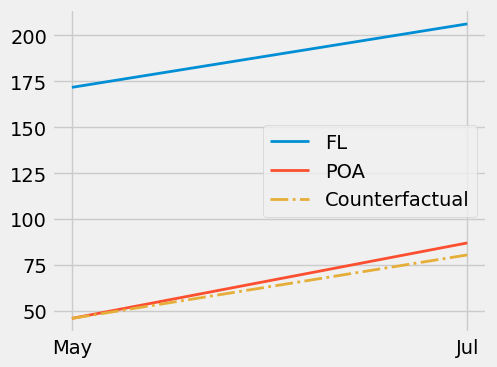

In [5]:
plt.figure(figsize=(5,4))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend()
plt.show()
plt.close()

What do we do when this assumption is not verified? One way is to create a synthetic new variable looking like the treated. <br/>
Analysis: we want to know whether Proposition 99 had an effect on cigarette consumption. <br/>
We gather data on cigarette sales from multiple states, from the year 1970 to 2000 and from 39 states. <br/>


In [6]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


Covariates are `retprice`, the cigarette retail price, and `cigsale`, the per-capita sales of cigarettes in packs. The outcome variable of interest is `cigsale`. Finally, we have boolean helper variables to signal the state of California and the post intervention period. If we plot the sales of cigarettes for California and other states across time, this is what we would get.

In [7]:
data_tmp = cigar.assign(california = np.where(cigar["california"], "California", "Other States"))\
 .groupby(["year", "california"])\
 ["cigsale"]\
 .mean()\
 .reset_index()\
 .pivot("year", "california", "cigsale")

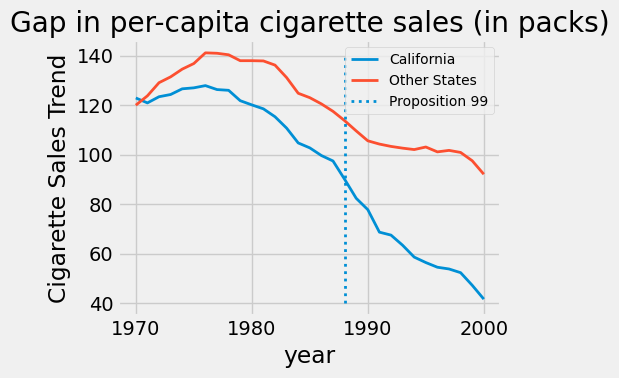

In [8]:
ax = plt.subplot(1, 1, 1)

data_tmp.plot(ax=ax, figsize=(5,4), lw=2)
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
plt.close()

By examining the plot, people in California apparently bought less cigarettes than the national average. Also, it appears to be a decreasing movement in cigarette consumption after the 80s: it looks like after Proposition 99 the decreasing trend accelerated for California, compared to other states.

1. To answer the question of whether `Proposition 99` had an effect on cigarette consumption, we will use the pre-intervention period to build a **synthetic control**. 
2. We will combine the other states to build a fake state that resembles very closely to the trend of California. Then, we will see how this synthetic control behaves after the intervention.

To build the synthetic control we will use OLS; the other states as features and the outcome variable as the state of California.

In [9]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

In [10]:
from sklearn.linear_model import LinearRegression
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [11]:
data_tmp = cigar.query("~california").pivot(index='year', columns="state")["cigsale"]
data_tmp.head()

state,1,2,4,5,6,7,8,9,10,11,...,30,31,32,33,34,35,36,37,38,39
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003


In [12]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

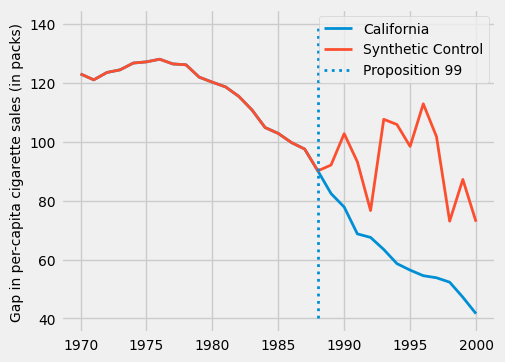

In [13]:
plt.figure(figsize=(5,4))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California", lw=2)
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control", lw=2)
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize=10);

The synthetic control is able to match the state of California exactly. This is a sign that our synthetic control model is probably overfitting the data. Also note the huge variance on the outcome variable of the synthetic control after the intervention.

To address the overfitting, we could use Lasso or Ridge.
But we also want the weights to be positive and sum up to one. 

In [14]:
from functools import partial
from typing import List
from operator import add
from scipy.optimize import fmin_slsqp

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))


def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [15]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

Now we can multiply these weights by the states as we did before.

In [16]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

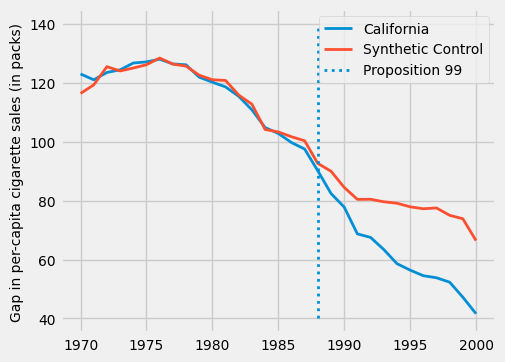

In [17]:
plt.figure(figsize=(5,4))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California", lw=2)
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control", lw=2)
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize=10)
plt.show()
plt.close()

We can estimate the treatment effect as the gap between treated and the synthetic control.

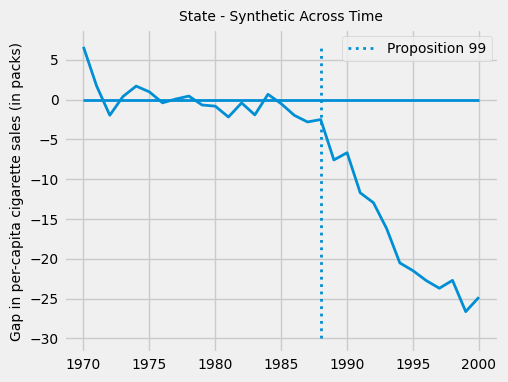

In [18]:
plt.figure(figsize=(5,4))
plt.plot(cigar.query("california")["year"],cigar.query("california")["cigsale"] - calif_synth, lw=2)
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time", fontsize=10)
plt.ylabel("Gap in per-capita cigarette sales (in packs)", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize=10)
plt.show()
plt.close()

By the year 2000, it looks like Proposition 99 has reduced the sales in cigarettes by 25 packs.

To understand if the result is statistically significant, we are going to create multiple tests by permuting
the treated and control. For each state, we pretent it is the treated and the others are the control.
Then we will see if the treatment in `California` is sufficiently large compared to the other fake treatments.

In [19]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [20]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


In [21]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [22]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


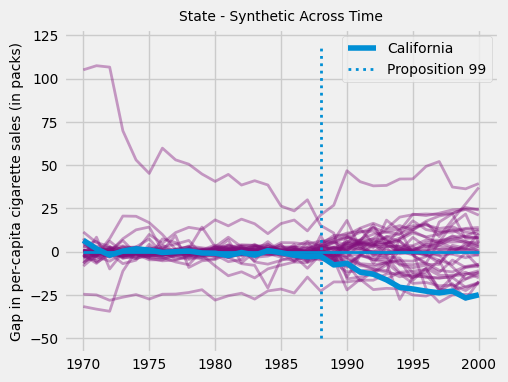

In [23]:
plt.figure(figsize=(5,4))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4, lw=2)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.ylabel("Gap in per-capita cigarette sales (in packs)", fontsize=10)
plt.title("State - Synthetic Across Time", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize=10)
plt.show()
plt.close()

We can see from the plot the variance is higher before the intervention and some synthetic states can't fit very well 
even before in the pre-intervention period. Since those states are so poorly fit, 
it is a good idea to remove them from the analysis. 
One way to do it objectively is to set a threshold for pre-intervention error: <br/>
$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$
and remove those units with high error. 

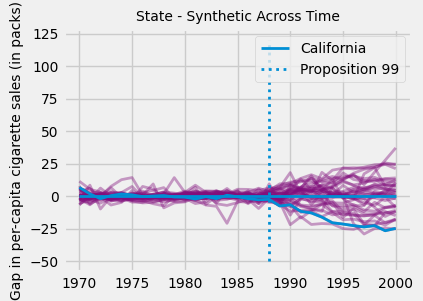

In [24]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(4,3))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4, lw=2)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California", lw=2);

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.ylabel("Gap in per-capita cigarette sales (in packs)", fontsize=10)
plt.title("State - Synthetic Across Time", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize=10)
plt.show()
plt.close()

This image shows us that if we pretend the treatment had happened to any other state, we would almost never get an effect so extreme as the one we got with California.

In [25]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)

California Treatment Effect for the Year 2000: -24.83015975607075


We show the distribution of effects just to get a sense of how extreme the value of the effect in California really is.

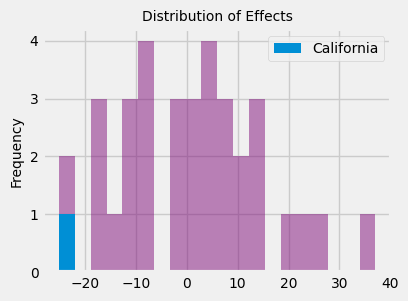

In [26]:
plt.figure(figsize=(4,3))
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frequency", fontsize=10)
plt.title("Distribution of Effects", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize=10)
plt.show()
plt.close()